<a href="https://colab.research.google.com/github/davidlealo/TalkTrack/blob/main/TalkTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TalkTrack

In [1]:
!pip install opencv-python-headless numpy openai-whisper sounddevice moviepy torch torchvision ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 15.3 MB/s eta 0:00:00


Starting YOLO detection. Click on 'Stop Stream' to stop.


<IPython.core.display.Javascript object>


0: 480x640 (no detections), 8.0ms
Speed: 1.5ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


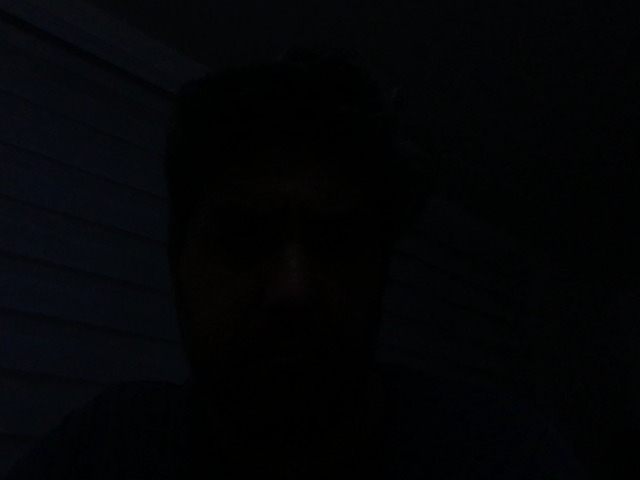


0: 480x640 1 person, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


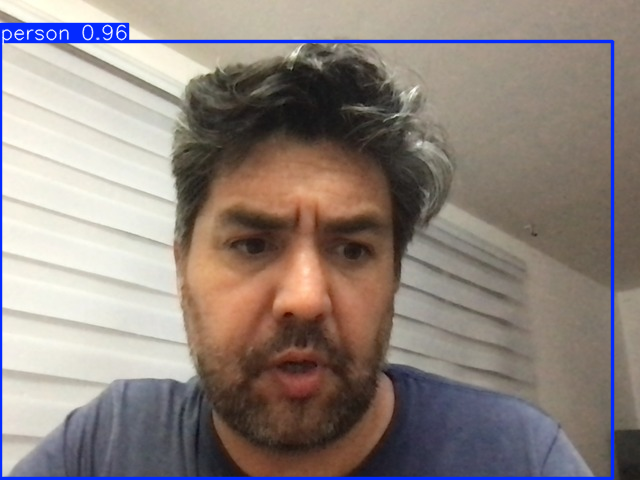


0: 480x640 1 person, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


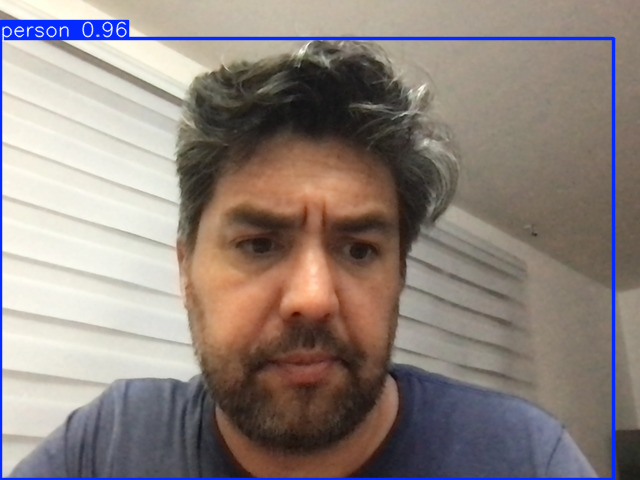


0: 480x640 1 person, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


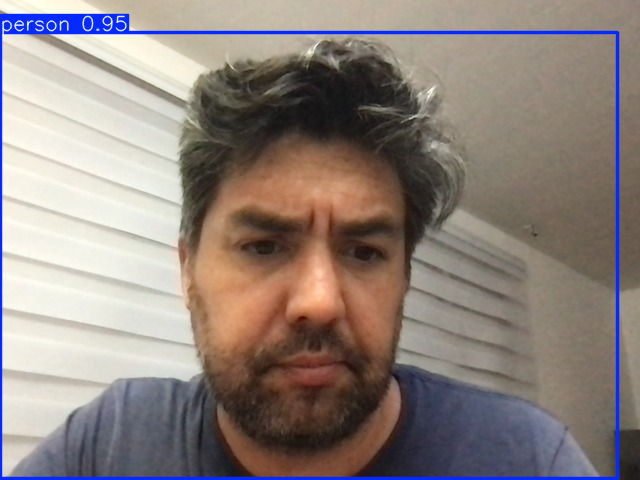

Stream stopped by user.


In [12]:
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from base64 import b64decode
import time

# Load YOLO model (YOLOv8n for lightweight detection)
model = YOLO("yolov8n.pt")

# Function to convert JavaScript object into an OpenCV image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# JavaScript for webcam streaming with shutdown control
def video_stream():
    display(Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var shutdown = false;

        function removeDom() {
           if (stream) {
               stream.getTracks().forEach(track => track.stop());
           }
           if (video) {
               video.remove();
           }
           if (div) {
               div.remove();
           }
           video = null;
           div = null;
           stream = null;
           captureCanvas = null;
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '640px';
            document.body.appendChild(div);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };

            stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            div.appendChild(video);

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = video.videoWidth;
            captureCanvas.height = video.videoHeight;

            const stopButton = document.createElement('button');
            stopButton.textContent = 'Stop Stream';
            stopButton.style.marginTop = '10px';
            stopButton.onclick = () => { shutdown = true; };
            div.appendChild(stopButton);

            return stream;
        }

        async function captureFrame() {
            if (!div) await createDom();
            if (shutdown) {
                removeDom();
                return 'shutdown';
            }
            captureCanvas.getContext('2d').drawImage(video, 0, 0, captureCanvas.width, captureCanvas.height);
            return captureCanvas.toDataURL('image/jpeg');
        }

        google.colab.kernel.invokeFunction('notebook.captureFrame', {}, {}).then(captureFrame);
    '''))

# Function to capture webcam frames and run YOLO inference
def capture_and_detect():
    video_stream()
    try:
        while True:
            js_reply = eval_js("captureFrame()")
            if js_reply == 'shutdown':
                print("Stream stopped by user.")
                break

            frame = js_to_image(js_reply)
            results = model.predict(source=frame, conf=0.5)

            for result in results:
                annotated_frame = result.plot()
                cv2_imshow(annotated_frame)
            time.sleep(0.1)

    except Exception as e:
        print("Error during detection:", e)

if __name__ == "__main__":
    print("Starting YOLO detection. Click on 'Stop Stream' to stop.")
    capture_and_detect()
